In [5]:
from __future__ import division

from pylab import *
import scipy
import time
import utils
import hrr_utils
import RM_utils

#import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
from scipy import stats

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

In [141]:
def ngram_encode(ngram_str, letter_vecs, alph):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, alph):
    vec = ngram_encode(ngram_str, letter_vecs, alph)
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) > 0) - 1

def initialize(letter_vecs, N, D, state_length=5, n_steps=500):
    states = []
    coef_hists = []
    
    for i in range(state_length):
        states.append(np.random.randn(N))
    
    for i in range(1, state_length-1):
        states[i] = np.dot(letter_vecs.T, np.dot(states[i], letter_vecs.T))

    for i in range(1, state_length-1):
        states[i] = states[i]/norm(states[i])

    states[0] = letter_vecs[alph.find('#'), :]
    states[state_length-1] = letter_vecs[alph.find('.'), :]
    
    for i in range(1, state_length-1):
        coef_hists.append(np.zeros((n_steps, D)))
    
    return states, coef_hists

def train(bound_vec, states, coef_hists, letter_vecs, n_steps=500):
    th_vec = bound_vec.copy()

    for i in range(n_steps):
        coef_hists[0][i, :] = np.dot(letter_vecs, states[1])
        coef_hists[1][i, :] = np.dot(letter_vecs, states[2])
        coef_hists[2][i, :] = np.dot(letter_vecs, states[3])

        mx1idx = np.argmax(np.abs(coef_hists[0][i,:]))
        states[1] *= np.sign(coef_hists[0][i, mx1idx])
        mx2idx = np.argmax(np.abs(coef_hists[1][i,:]))
        states[2] *= np.sign(coef_hists[1][i, mx2idx])
        mx3idx = np.argmax(np.abs(coef_hists[2][i,:]))
        states[3] *= np.sign(coef_hists[2][i, mx3idx])


        l1d = (np.roll(th_vec * states[0] * np.roll(states[2], 2), -1) +
              th_vec * np.roll(states[2], 1) * np.roll(states[3], 2)) / 2

        l2d = (np.roll(th_vec * states[0] * np.roll(states[1], 1), -2) +
                np.roll(th_vec * states[1] * np.roll(states[3], 2), -1) +
                  th_vec * np.roll(states[3], 1) * np.roll(states[4], 2)) / 3

        l3d = (np.roll(th_vec * states[2] * np.roll(states[4], 2), -1) +
               np.roll(th_vec * states[1] * np.roll(states[2], 1), -2)) / 2

        states[1] = np.dot(letter_vecs.T, np.dot(l1d, letter_vecs.T)/N) + 1.0*states[1]
        states[2] = np.dot(letter_vecs.T, np.dot(l2d, letter_vecs.T)/N) + 1.0*states[2]
        states[3] = np.dot(letter_vecs.T, np.dot(l3d, letter_vecs.T)/N) + 1.0*states[3]

        bv = (states[0] * np.roll(states[1],1) * np.roll(states[2],2) 
              +states[1] * np.roll(states[2],1) * np.roll(states[3],2) 
              +states[2] * np.roll(states[3],1) * np.roll(states[4],2) )

        th_vec = bound_vec - bv
    return states, coef_hists
        

def explain_away(bound_vec, states, coef_hists, state_length, letter_vecs, N, D, max_steps=500, atol=0.034, rtol=0.264):
    th_vec = bound_vec.copy()
    all_converged = np.zeros(state_length-2)
    for i in range(max_steps):

        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])
            if i > 1:
                all_converged[j-1] = np.allclose(coef_hists[j-1][i,:], coef_hists[j-1][i-1, :],
                                                atol=atol, rtol=rtol)

        
        for j in range(1, state_length-1):
            mxidx = np.argmax(np.abs(coef_hists[j-1][i,:]))
            states[j] *= np.sign(coef_hists[j-1][i, mxidx])
        ljds = []
        for j in range(1, state_length-1):
            if j == 1:
                ljds.append(
                    (np.roll(th_vec * states[0] * np.roll(states[2], 2), -1) +
                    th_vec * np.roll(states[2], 1) * np.roll(states[3], 2)) / 2
                )
            elif 1 < j < state_length-2:
                ljds.append(
                    (np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                    np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                      th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
                )
            else:
                ljds.append(
                    (np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                   np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2
                )

        for j in range(1, state_length-1):    
            states[j] = np.dot(letter_vecs.T, np.dot(ljds[j-1], letter_vecs.T)/N) + 1.0*states[j]
        
        if np.all(all_converged):
            break
            
        bv = states[0] * np.roll(states[1],1) * np.roll(states[2],2)  
        for j in range(1, state_length-2):
            bv += states[j] * np.roll(states[j+1],1) * np.roll(states[j+2],2) 
         
        th_vec = bound_vec - bv

    return states, coef_hists, all_converged, i

def spell(coef_hists):
    pred = ''

    for i in range(len(coef_hists)):
        pred += alph[np.argmax(np.abs(coef_hists[i][-1,:]))]

    return pred
    
def resplot(word_length, states, coef_hists, N, nsteps, start):
    
    pred = spell(coef_hists)
    
    rows = 1
    columns = word_length

    fig, axes = plt.subplots(rows, columns, sharex='all', squeeze=True, figsize=(25,5))
    cols = get_cmap('copper', min(500,n_steps))
    x = np.linspace(0,len(alph)-2,len(alph)-2)
    labels = list(alph)
    plt.xticks(x, labels)
    
    for j in range(word_length):
        for i in range(start, min(500,n_steps)):
            # graphing the max positive at every iteration is not intuitive, since we should
            # be focusing on how our predicted letter's probability increases over time
            coef_hists[j][i,alphis[j]] = np.abs(coef_hists[j][i,alphis[j]])
            axes[j].plot(coef_hists[j][i,:], lw=1.7, c=cols(i))
            
        step, alphi = np.unravel_index(coef_hists[j].argmax(), coef_hists[j].shape)
        axes[j].plot(alphi, coef_hists[j][step, alphi], '+')
#         print ('alphi', alphi)
    #plt.savefig('figures/'+title+pred+'-N='+str(N)+'-steps='+str(nsteps)+'-reg='+reg+'.svg')
    
def accuracy(pred, actual):
    acc = 0
    for i in range(len(pred)):
        if pred[i] == actual[i]:
            acc += 1
    return acc / float(len(pred))


In [133]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 10000
D = len(alph)

dic1 = 2 * (np.random.randn(D, N) < 0) - 1
dic2 = 2 * (np.random.randn(D, N) < 0) - 1

word = 'pneumonoultramicroscopicsilicovolcanoconiosis'


In [137]:
pres_categories, past_categories = RM_utils.exemplars()
verbs = []
testverbs = []
rat = 2/3

for key in pres_categories.keys():
    total = len(past_categories[key])
    cutoff = int(total*rat)
    for i in range(total):
        if i < cutoff:
            verbs.append([past_categories[key][i], pres_categories[key][i]])
        else:
            testverbs.append([
                past_categories[key][i],
                pres_categories[key][i]
            ])

verbs.append(['jumped', 'jump'])
verbs.append(['walked', 'walk'])
testverbs.append(['jolted', 'jolt'])

verbs = verbs[:10]
testverbs = testverbs[:5]


In [138]:
diff, pres1, pres2, past1, past2 = RM_utils.genX(verbs, N, dic1, dic2, alph)
testdiff, testpres1, testpres2, testpast1, testpast2 = RM_utils.genX(testverbs, N, dic1, dic2, alph)

bound_vec = np.zeros(N)
bound_vec = RM_utils.train_diff_bulk(bound_vec, past2, pres1, pres2, N)

('slqk', 'beat', 499)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: overflow encountered in multiply


('aaa', 'fit', 499)
('ij#', 'set', 499)
('ae#nns', 'spread', 499)
('gun', 'hit', 499)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in add


('aaa', 'cut', 499)
('tqymr', 'built', 499)
('gydh', 'sent', 499)
('jki#m', 'spent', 499)


/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: overflow encountered in multiply
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in add
/home/quinn/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in add


('aaaa', 'felt', 499)
test set
('aaa', 'put', 78)
('jxxw#t', 'thrust', 499)


IndexError: list index out of range

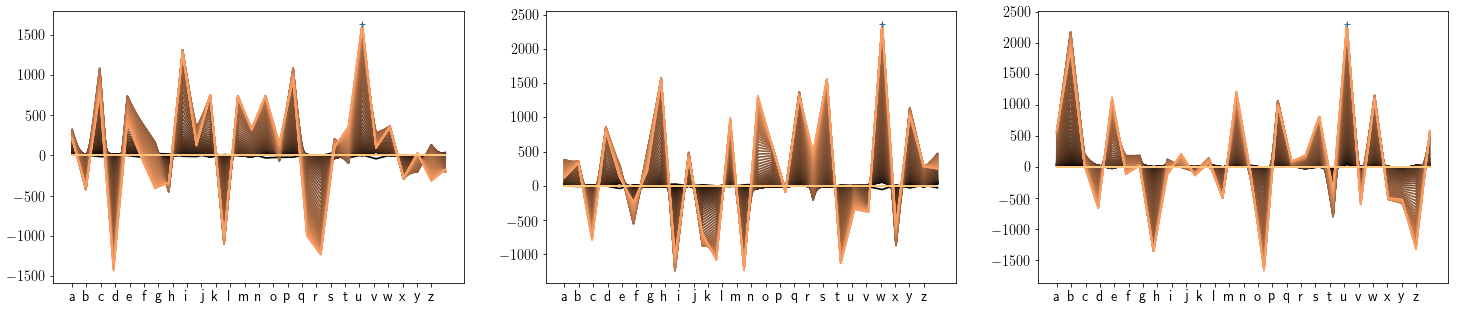

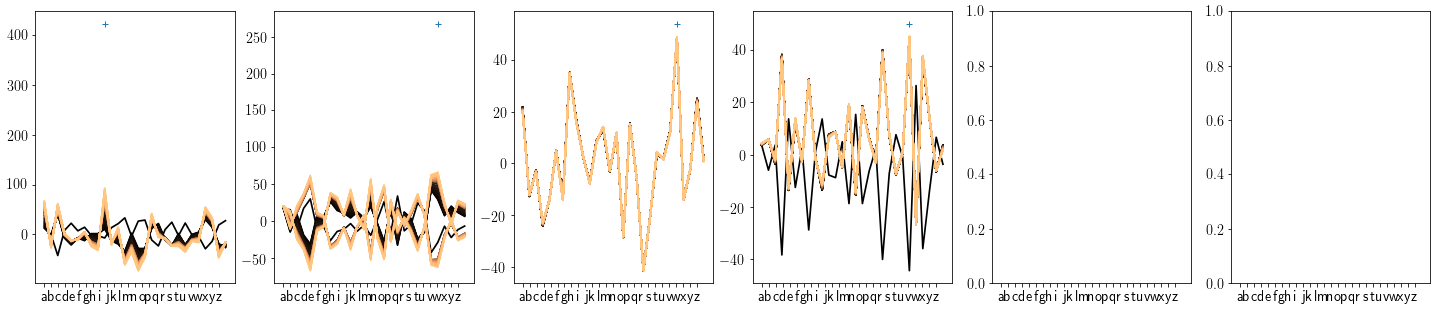

In [140]:
nsteps = 500
n_steps = 100
atol = 0.034
rtol = 0.264

# train set
for i in range(len(verbs)):
    past, pres = verbs[i][0], verbs[i][1]
    word_length = len(past)
    pred_vec = pres1[i] * bound_vec + pres2[i]

    states, coef_hists = initialize(dic2, N, D, word_length+2, nsteps)
    states, coef_hists, all_converged, steps = explain_away(
        bound_vec, states, coef_hists, word_length+2, dic2, 
        N, D, nsteps, atol, rtol)

#     states, coef_hists = state_setup(word_length+2, dic2, N, D, n_steps)
#     states, coef_hists = explain_away_iterate(
#         pred_vec, states, coef_hists, word_length+2, dic2, N, D, n_steps)
    
    pred = spell(coef_hists)
    print (pred, past, steps)

#     resplot(word_length, states, coef_hists, N, nsteps, 0)
    
#     resplot(word_length, states, coef_hists, N, n_steps, 0)
print ('test set')
for i in range(len(testverbs)):
    past, pres = testverbs[i][0], testverbs[i][1]
    word_length = len(past)
    pred_vec = testpres1[i] * bound_vec + testpres2[i]
    
    states, coef_hists = initialize(dic2, N, D, word_length+2, nsteps)
    states, coef_hists, all_converged, steps = explain_away(
        bound_vec, states, coef_hists, word_length+2, dic2, 
        N, D, nsteps, atol, rtol)

#     states, coef_hists = state_setup(word_length+2, dic2, N, D, n_steps)
#     states, coef_hists = explain_away_iterate(
#         pred_vec, states, coef_hists, word_length+2, dic2, N, D, n_steps)
    
    pred = spell(coef_hists)

    print (pred, past, steps)

    resplot(word_length, states, coef_hists, N, nsteps, 0)
    
#     resplot(word_length, states, coef_hists, N, n_steps, 0)

In [245]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 1000
D = len(alph)

letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1


ngram_str = 'pax'

bound_vec = ngram_encode_cl(ngram_str, letter_vecs, alph)

nsteps = 100
atol = 0.034
rtol = 0.0264
state_length = 5

states, coef_hists = initialize(letter_vecs, N, D, state_length, nsteps)
states1, coef_hists1 = copy(states), copy(coef_hists)
    
states, coef_hists = train(bound_vec, states, coef_hists, letter_vecs, nsteps)
states1, coef_hists1, all_converged, steps = explain_away(
    bound_vec, states1, coef_hists1, state_length, 
    letter_vecs, N, D, nsteps, atol, rtol)

pred = spell(coef_hists)
pred1 = spell(coef_hists1)
print (pred, pred1, steps)

('pax', 'pax', 99)


In [246]:
print ('states')
for i in range(len(states1)):
    print np.all(states[i] == states1[i])
print ('coef_hists')
for i in range(len(coef_hists1)):
    print np.all(coef_hists[i] == coef_hists1[i])

states
True
True
True
True
True
coef_hists
True
True
True


('iqz', 99)


99
